# CS470 인공지능개론
## Deep Learning Practice 
#### Prof. Ho-Jin Choi
#### School of Computing, KAIST

---

### 3-4. Image classification using CNN

In this notebook, we will implement a convolutional neural network (CNN) to classify cats or dogs from image. It builds an image classifier using a `tf.keras.Sequential` model and load data using [`tf.keras.preprocessing.image.ImageDataGenerator`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). ImageDataGenerator class will be used for building _data input pipelines_ to efficiently work with data on disk to use with the model. Besides, this will be used for _data augmentation_ as a technique to fight overfitting in computer vision tasks. 

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

#### Download the dataset

Let's begin by downloading the cats and dogs images. In this practice, we are going to use a filtered version of [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data) dataset from Kaggle.

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# Basically, data will be stored in ~/.keras/dataset/
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
print(PATH)

68608000/68606236 [==============================] - 2s 0us/step
/root/.keras/datasets/cats_and_dogs_filtered


The dataset has the following directory structure:

cats_and_dogs_filtered  
|__ train  
&emsp;|____________ cats: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]  
&emsp;|____________ dogs: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]  
|__ validation  
&emsp;|____________ cats: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]  
&emsp;|____________ dogs: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]  

In [3]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [4]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

Let's look at how many cats and dogs images are in the training and validation directory:

In [17]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [18]:
print('Total training cat images:', num_cats_tr)
print('Total training dog images:', num_dogs_tr)

print('Total validation cat images:', num_cats_val)
print('Total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 500
Total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


For convenience, set up variables to use while pre-processing the dataset and training the network.

In [7]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

#### Load the dataset
To feed the images to the network, we first transform the images into appropriately **pre-processed floating point tensors**:

1. Read images from the disk.
1. Decode contents of these images and convert it into proper grid format as per their RGB content.
1. Convert them into floating point tensors.
1. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`. It can read images from disk and **preprocess them into proper tensors**. It will also set up generators that **convert these images into batches** of tensors—helpful when training the network.

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# TODO: Define the generators for training and validation images with rescaling factor
train_image_generator = ImageDataGenerator(rescale=1/255)
validation_image_generator = ImageDataGenerator(rescale=1/255)

By using the `flow_from_directory()` method, let's load images from the disk, apply rescaling, and resize the images into the required dimensions.


In [9]:
# TODO: Load training images from the disk
train_data_gen = train_image_generator.flow_from_directory(
    batch_size = batch_size,
    directory = train_dir,
    shuffle = True,
    target_size = (IMG_HEIGHT, IMG_HEIGHT),
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.


In [10]:
# TODO: Load validation images from the disk
val_data_gen = validation_image_generator.flow_from_directory(
    batch_size = batch_size,
    directory = validation_dir,
    target_size = (IMG_HEIGHT, IMG_HEIGHT), #150by150
    class_mode = 'binary'
)

Found 1000 images belonging to 2 classes.


#### Visualize the dataset
Let's visualize the training images by extracting a batch of images from the training generator—which is 128 images in this notebook—then plot five of them with `matplotlib`.

In [11]:
sample_training_images, _ = next(train_data_gen) 
print("shape of sample_training_images =", sample_training_images.shape) #128 pictures in one batch, with size 150*150*3
print("dtype of sample_training_images =", sample_training_images.dtype)
print("max of sample_training_images =", sample_training_images.max())
print("min of sample_training_images =", sample_training_images.min())


shape of sample_training_images = (128, 150, 150, 3)
dtype of sample_training_images = float32
max of sample_training_images = 1.0
min of sample_training_images = 0.0


The `next()` function returns a batch from the dataset. The return value of `next()` function is in form of `(x_train, y_train)` where `x_train` is training features and `y_train`, its labels. We will discard the labels here to only visualize the training images.

In [12]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

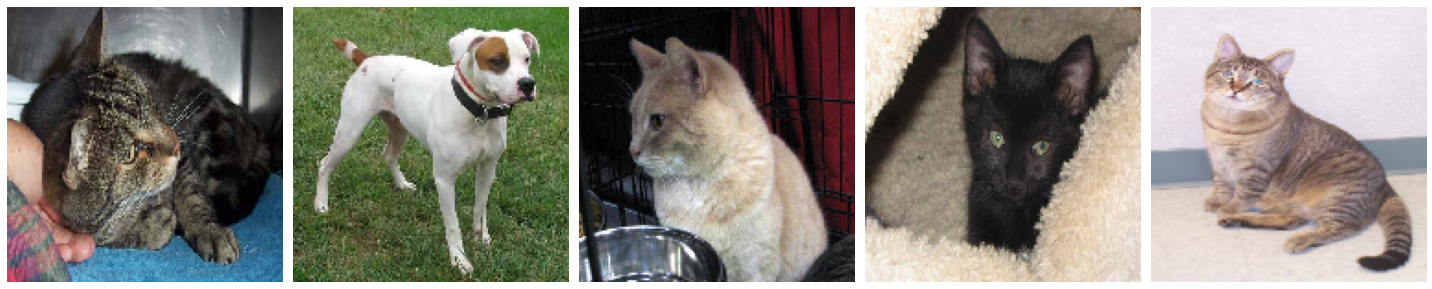

In [13]:
plotImages(sample_training_images[:5])

#### Define the model 
Let's define a convolutional neural network which consists of three convolution blocks with a max pool layer in each of them. After them, we will add a fully connected layer with 512 units that is activated by a `relu` function. And then, we will add the last fully connected layer with 1 neuron that is activated by a `sigmoid` function to produce a class probability based on binary classification.

In [14]:
# TODO: Define a convolutional neural networks using tf.keras.Sequential
model = tf.keras.Sequential([
   # TODO: Add a convolution block with filters=16, kernel_size=3, padding='same' and activation='relu'
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    # TODO: Add a max pool layer
    tf.keras.layers.MaxPool2D(),
    
    # TODO: Add a convolution block with filters=32, kernel_size=3, padding='same' and activation='relu'
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    # TODO: Add a max pool layer
    tf.keras.layers.MaxPool2D(),
    
    # TODO: Add a convolution block with filters=64, kernel_size=3, padding='same' and activation='relu'
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    # TODO: Add a max pool layer
    tf.keras.layers.MaxPool2D(),
    
    # TODO: Add a flatten layer
    tf.keras.layers.Flatten(),
    # TODO: Add a fully-connected layer with 512 units activated by relu
    tf.keras.layers.Dense(512, activation='relu'),
    
    # TODO: Add a fully-connected layer with 1 unit activated by sigmoid
    tf.keras.layers.Dense(1, activation='sigmoid'),
    
])

#### Compile the model
Let's compile the model using the adam optimizer and binary cross entropy loss function.

In [15]:
# TODO: Compile the model with the following parameters:
# - optimizer: adam
# - loss: binary crossentropy
# - metrics: accuracy
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

#### Train the model 
Since we have loaded the dataset using `ImageDataGenerator()`, we should train the model using the `fit()` method.

- `steps_per_epoch`: Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch.   
- `validation_steps`:  Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.

In [16]:
# TODO: Train the model using `fit()`
history = model.fit(
    train_data_gen,
    validation_data = val_data_gen,
    epochs=epochs,
    steps_per_epoch = total_train // batch_size,
    validation_steps = total_val // batch_size
)

Epoch 1/15
15/15 [==============================] - 12s 696ms/step - loss: 1.2232 - accuracy: 0.4649 - val_loss: 0.6921 - val_accuracy: 0.4967
Epoch 2/15
15/15 [==============================] - 9s 640ms/step - loss: 0.6942 - accuracy: 0.4934 - val_loss: 0.6882 - val_accuracy: 0.5067
Epoch 3/15
15/15 [==============================] - 9s 638ms/step - loss: 0.6848 - accuracy: 0.5305 - val_loss: 0.6927 - val_accuracy: 0.5301
Epoch 4/15
15/15 [==============================] - 9s 629ms/step - loss: 0.6821 - accuracy: 0.5583 - val_loss: 0.6559 - val_accuracy: 0.6038
Epoch 5/15
15/15 [==============================] - 9s 626ms/step - loss: 0.6492 - accuracy: 0.6112 - val_loss: 0.6195 - val_accuracy: 0.6574
Epoch 6/15
15/15 [==============================] - 9s 629ms/step - loss: 0.5986 - accuracy: 0.6824 - val_loss: 0.6148 - val_accuracy: 0.6629
Epoch 7/15
15/15 [==============================] - 9s 632ms/step - loss: 0.5485 - accuracy: 0.7376 - val_loss: 0.5982 - val_accuracy: 0.7054
Epoch

#### Visualize training results
Let's visualize the results after training the network.

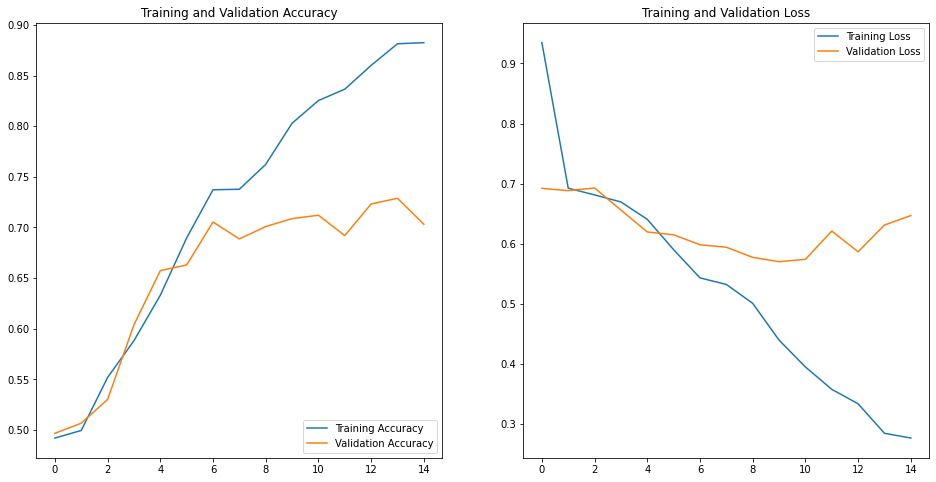

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As we can see from the plots, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 70% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable. Thus, we can think that this is the overfitting problem as we checked in previous class. 

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as _overfitting_. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this notebook, we'll use *data augmentation* and add *dropout* to our model.

#### Data augmentation
Overfitting generally occurs when there are a small number of training examples. One way to fix this problem is to augment the dataset so that it has a sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples using random transformations that yield believable-looking images. The goal is the model will never see the exact same picture twice during training. This helps expose the model to more aspects of the data and generalize better.

Since `ImageDataGenerator` supports a lot of transformations, we can easily augment the dataset and it will take care of applying it during the training process.

- `ImageDataGenerator`
    - featurewise_center
    - samplewise_center
    - featurewise_std_normalization
    - samplewise_std_normalization
    - zca_epsilon
    - zca_whitening
    - rotation_range
    - width_shift_range
    - height_shift_range
    - brightness_range
    - shear_range
    - zoom_range
    - fill_mode
    - cval
    - horizontal_flip
    - vertical_flip
    - preprocessing_function

##### Horizontal flip

Pass `horizontal_flip` as an argument to the `ImageDataGenerator` class and set it to True to apply this augmentation.

In [ ]:
# TODO: Create `ImageDataGenerator` which applies horizontal flip
image_gen = image_gen = ImageDataGenerator(rescale=1/255, horizontal_flip=True)

In [ ]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Let's take one sample image from the training examples and repeat it five times so that the augmentation is applied to the same image five times.

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Random rotation
Let's take a look at a different augmentation called rotation and apply 45 degrees of rotation randomly to the training examples.

In [ ]:
# TODO: Create `ImageDataGenerator` which applies random rotation
image_gen = image_gen = ImageDataGenerator(rescale=1/255, rotation_range=45)

In [ ]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

##### Zoom
Apply a zoom augmentation to the dataset to zoom images up to 50% randomly.

In [ ]:
# TODO: Create `ImageDataGenerator` which applies zoom
image_gen = image_gen = ImageDataGenerator(rescale=1/255, zoom_range=0.5)

In [ ]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

##### Put it all together
Let's apply all the above augmentations. Here, we also applied `rescale`, `width shift` and `height shift` augmentation to the training images.

In [ ]:
# TODO: Create `ImageDataGenerator` which applies rescale, rotation, width shift, height shift, horizontal flip and zoom
image_gen_train = image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5)

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Let's visualize how a single image would look five different times when passing these augmentations randomly to the dataset.

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### Create the validation data generator
Generally, we only apply data augmentation to the training examples. Therefore, we will only rescale the validation images and convert them into batches using `ImageDataGenerator`.

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [ ]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

#### Define a new network with dropouts
Here, we will apply dropout to first and last max pool layers with dropout rate of 0.2

In [ ]:
# TODO: Define a convolutional neural networks using tf.keras.Sequential
model_new = tf.keras.Sequential([
    
    # TODO: Add a convolution block with filters=16, kernel_size=3, padding='same' and activation='relu'
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    # TODO: Add a max pool layer
    tf.keras.layers.MaxPool2D(),
    # TODO: Add a dropout layer with rate of 0.2
    tf.keras.layers.Dropout(0.2),
    # TODO: Add a convolution block with filters=32, kernel_size=3, padding='same' and activation='relu'
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    # TODO: Add a max pool layer
    tf.keras.layers.MaxPool2D(),
    # TODO: Add a convolution block with filters=64, kernel_size=3, padding='same' and activation='relu'
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    # TODO: Add a max pool layer
    tf.keras.layers.MaxPool2D(),
    # TODO: Add a dropout layer with rate of 0.2
    tf.keras.layers.Dropout(0.2),
    # TODO: Add a flatten layer
    tf.keras.layers.Flatten(),
    # TODO: Add a fully-connected layer with 512 units activated by relu
    tf.keras.layers.Dense(512, activation='relu'),
    # TODO: Add a fully-connected layer with 1 unit activated by sigmoid
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

#### Compile the model
After introducing dropouts to the network, compile the model.

In [ ]:
# TODO: Compile the model with the following parameters:
# - optimizer: adam
# - loss: binary crossentropy
# - metrics: accuracy
model_new.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#### Train the model
After successfully introducing data augmentations to the training examples and adding dropouts to the network, train this new network:

In [ ]:
# TODO: Train the model using `fit()`
history = model_new.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
) 

#### Visualize the model
Let's visualize the performance trend of the new model after training, we can see that there is significantly less overfitting than before. The accuracy should go up after training the model for more epochs.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Train more epoch

![train 50 epoch](https://github.com/keai-kaist/CS470/blob/main/Lab2/May%204/images/train-50-epoch.png?raw=true)